# CO460 - Deep Learning - Lab exercise 4

## Introduction

In this exercise, you will experiment with a GAN and a Conditional GAN architecture.
You are asked to:

1.  Experiment with the architectures
2.  Define the training strategy
3.  Investigate and implement sampling and interpolation in the latent space.

In [59]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from utils import *
import matplotlib.pyplot as plt
import numpy as np

### Device selection

In [60]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [61]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [62]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("./data/", train=False, transform=transform)

denorm = denorm_for_tanh

if not os.path.exists('./cGAN'):
    os.mkdir('./cGAN')
    
if not os.path.exists('./GAN'):
    os.mkdir('./GAN')

### Hyper-parameter selection

In [63]:
"""
TODO: Define here your hyperparameters
"""

num_epochs = None
batch_size = None
learning_rate = None
noise_dim = None


in_dim = np.prod(train_dat[0][0].shape)
out_shape = train_dat[0][0].shape
sample_interval = 5

In [67]:
num_epochs = 20
batch_size = 128
learning_rate = 0.01
noise_dim = 784
in_dim = np.prod(train_dat[0][0].shape)
out_shape = train_dat[0][0].shape

train_loader = DataLoader(train_dat, batch_size, shuffle=True, num_workers=16)
test_loader = DataLoader(test_dat, batch_size, shuffle=False, num_workers=16)


### Define the model

In [153]:
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        """
        TODO: Layer definitions for the Generator
        """
        self.hidden0 = nn.Sequential(nn.Linear(noise_dim, 256), nn.ReLU())
        self.batch_norm0 = nn.BatchNorm1d(784)
        self.hidden1 = nn.Sequential(nn.Linear(256, 512), nn.ReLU())
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.hidden2 = nn.Sequential(nn.Linear(512, 1024), nn.ReLU())
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.out = nn.Sequential(nn.Linear(1024, 784), nn.Tanh())

    def forward(self, x):
    
        """
        TODO: Generator pipeline. Your output should have the same dimensions as the real images
        """
        x = self.hidden0(self.batch_norm0(x))
        x = self.hidden1(self.batch_norm1(x))
        x = self.hidden2(self.batch_norm2(x))
        x = self.out(x)
        x = x.view(x.size(0), -1)
        return x
    
    
    
    
    
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        """
        TODO: Layer definitions for the Discriminator
        """
        self.batch_norm0 = nn.BatchNorm1d(784)
        self.hidden0 = nn.Sequential(nn.Linear(784, 1024), nn.ReLU())
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.hidden1 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.hidden2 = nn.Sequential(nn.Linear(512, 256),nn.ReLU())
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.out = nn.Sequential(nn.Linear(256, 1), nn.Sigmoid())

    def forward(self, x):
        """
        TODO: Discriminator pipeline. Your output should have only one dimension.
        """
        x = x.view(x.size(0), -1)
        x = self.hidden0(self.batch_norm0(x))
        x = self.hidden1(self.batch_norm1(x))
        x = self.hidden2(self.batch_norm2(x))
        x = self.out(self.batch_norm3(x))
            
        return x


In [154]:
generator = Generator()
discriminator = Discriminator()


### Define Loss function

In [155]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Initialize Model and print number of parameters

In [156]:
generator = generator.to(device)
discriminator = discriminator.to(device)

params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print("Total number of generator parameters is: {}".format(params))  # what would the number actually be
print(generator)

params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print("Total number of discriminator parameters is: {}".format(params))  # what would the number actually be
print(discriminator)

Total number of generator parameters is: 1664560
Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (batch_norm0): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
  )
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
  )
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)
Total number of discriminator parameters is: 1465377
Discriminator(
  (batch_norm0): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden0): Sequential(
    (0): Linear(in_features

### Choose and initialize optimizer

In [157]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

### Pick a noise distribution

In [158]:
def generate_noise(batch_size, noise_dim):
    """
    TODO: Define here your noise distribution (probably gaussian or uniform)
    """
    noise = torch.randn(batch_size, noise_dim)
    return noise                        

 ### Train

In [159]:
g_losses = []
d_losses = []
generator.train()
discriminator.train()
num_epochs = 200 
fixed_noise = generate_noise(batch_size, noise_dim)

for epoch in range(num_epochs):
    g_loss_epoch = 0
    d_loss_epoch = 0 
    for batch_idx, data in enumerate(train_loader):
        
        """
        TODO: Define here your training strategy
        """
        img, _ = data
        # 1) sample some real data, 2) assign a 1 as ground truth
        img = img.to(device)
        valid = torch.ones(img.size(0), 1, requires_grad=False).to(device)
        
        # 1) sample noise as generator input, 2) generate a batch of images, 3) assing a 0 as ground truth
        z = generate_noise(img.size(0), noise_dim).to(device)
        gen_imgs = generator(z)
        fake = torch.zeros(img.size(0), 1, requires_grad=False).to(device)
        
        ######Train Discriminator########
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = loss_function(discriminator(img), valid)
        fake_loss = loss_function(discriminator(gen_imgs.detach()), fake)
        d_loss = real_loss + fake_loss
        
        d_loss.backward()
        d_loss_epoch += d_loss.item()
        optimizer_D.step()
        
        ######Train Generator###########
        optimizer_G.zero_grad()
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = loss_function(discriminator(gen_imgs), valid)
        g_loss_epoch += g_loss.item()
        optimizer_G.step()


    print('epoch [{}/{}], generator loss:{:.4f}'
          .format(epoch + 1, num_epochs, g_loss_epoch / len(train_loader)))
    g_losses.append(g_loss_epoch/ len(train_loader))
    print('epoch [{}/{}], discriminator loss:{:.4f}'
          .format(epoch + 1, num_epochs, d_loss_epoch / len(train_loader)))
    d_losses.append(d_loss_epoch/ len(train_loader))
    if epoch % sample_interval == 0:
        save_image(denorm(generator(fixed_noise.to(device))).cpu(), './GAN/samples_epoch_{}.png'.format(epoch),nrow = 8)
    torch.save(generator.state_dict(), './GAN/generator.pth')
    torch.save(discriminator.state_dict(), './GAN/discriminator.pth')
    
np.save('./GAN/generator_losses.npy', np.array(g_losses))
np.save('./GAN/discriminator_losses.npy', np.array(d_losses))

epoch [1/200], generator loss:0.6948
epoch [1/200], discriminator loss:1.3896
epoch [2/200], generator loss:0.6932
epoch [2/200], discriminator loss:1.3863
epoch [3/200], generator loss:0.6931
epoch [3/200], discriminator loss:1.3863
epoch [4/200], generator loss:0.6932
epoch [4/200], discriminator loss:1.3863
epoch [5/200], generator loss:0.6932
epoch [5/200], discriminator loss:1.3863
epoch [6/200], generator loss:0.6932
epoch [6/200], discriminator loss:1.3863
epoch [7/200], generator loss:0.6932
epoch [7/200], discriminator loss:1.3863
epoch [8/200], generator loss:0.6932
epoch [8/200], discriminator loss:1.3863
epoch [9/200], generator loss:0.6932
epoch [9/200], discriminator loss:1.3863
epoch [10/200], generator loss:0.6932
epoch [10/200], discriminator loss:1.3863
epoch [11/200], generator loss:0.6932
epoch [11/200], discriminator loss:1.3863
epoch [12/200], generator loss:0.6932
epoch [12/200], discriminator loss:1.3863
epoch [13/200], generator loss:0.6932
epoch [13/200], disc

epoch [104/200], generator loss:0.6931
epoch [104/200], discriminator loss:1.3863
epoch [105/200], generator loss:0.6931
epoch [105/200], discriminator loss:1.3863
epoch [106/200], generator loss:0.6931
epoch [106/200], discriminator loss:1.3863
epoch [107/200], generator loss:0.6931
epoch [107/200], discriminator loss:1.3863
epoch [108/200], generator loss:0.6931
epoch [108/200], discriminator loss:1.3863
epoch [109/200], generator loss:0.6931
epoch [109/200], discriminator loss:1.3863
epoch [110/200], generator loss:0.6931
epoch [110/200], discriminator loss:1.3863
epoch [111/200], generator loss:0.6931
epoch [111/200], discriminator loss:1.3863
epoch [112/200], generator loss:0.6932
epoch [112/200], discriminator loss:1.3864
epoch [113/200], generator loss:0.6931
epoch [113/200], discriminator loss:1.3863
epoch [114/200], generator loss:0.6931
epoch [114/200], discriminator loss:1.3863
epoch [115/200], generator loss:0.6931
epoch [115/200], discriminator loss:1.3863
epoch [116/200],

### Loss curves

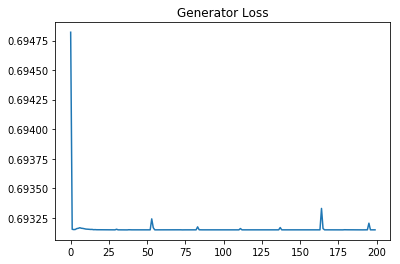

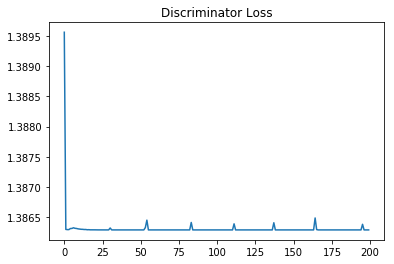

In [160]:
import matplotlib.pyplot as plt
generator_losses = np.load('./GAN/generator_losses.npy')
plt.plot(list(range(0,generator_losses.shape[0])), generator_losses)
plt.title('Generator Loss')
plt.show()

import matplotlib.pyplot as plt
discriminator_losses = np.load('./GAN/discriminator_losses.npy')
plt.plot(list(range(0,discriminator_losses.shape[0])), discriminator_losses)
plt.title('Discriminator Loss')
plt.show()

### Sampling

In [167]:
generator.load_state_dict(torch.load("./GAN/generator.pth"))

"""
TODO: Sample from the noise distribution
"""
"""
TODO: Do a linear interpolation in the latent space between two noise vectors and generate all the intermediate samples
"""
generator.eval()
n_samples = 32
with torch.no_grad():
    z = generate_noise(n_samples*n_samples, noise_dim).to(device)
    samples = generator(z)
    save_image(denorm(samples).type(torch.FloatTensor).cpu(), './GAN/samples'+'.png', nrow = n_samples)
    



## Conditional GAN

The concept of conditional GAN: 

* $\mathbf{x}$ refers to a train datum
* $\mathbf{y}$ refers to the corresponding label
* $\mathbf{z}$ refers to random noise vector
<img src="./imgs/cGAN.png" width="500" />

### Hyper-parameter selection

In [207]:
"""
TODO: Define here your hyperparameters
"""

num_epochs = None
batch_size = None
learning_rate = None

num_workers = 16
num_classes = 10
sample_interval = 5

############define hyperparameters##################
num_epochs = 20
batch_size = 128

learning_rate = 2e-4
beta_1 = 0.5
beta_2 = 0.999
latent_dim = 128

### Define the dataloaders

In [208]:
train_loader = DataLoader(train_dat, batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dat, batch_size, shuffle=False, num_workers=num_workers)
total_step = len(train_loader)

it = iter(test_loader)
sample_inputs, _ = next(it)

in_dim = sample_inputs.shape[-1] * sample_inputs.shape[-2]

### Define the Generator and the Discriminator

In [225]:
class Generator(torch.nn.Module):

    def __init__(self, latent_dim = 128, image_size=784):
        super(Generator, self).__init__()
        """
        TODO: Layer definitions for the Generator
        """
        self.fc1_1 = nn.Linear(latent_dim, 256)  #account for the noise z
        self.fc1_1_bn = nn.BatchNorm1d(256)
        self.fc1_2 = nn.Linear(10, 256)   #account for the labels
        self.fc1_2_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(512, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc3_bn = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, image_size)
        
    def forward(self, noise, labels):
    
        """
        TODO: Generator pipeline. Your output should have the same dimensions as the real images
        """
        x = F.relu(self.fc1_1_bn(self.fc1_1(noise)))
        y = F.relu(self.fc1_2_bn(self.fc1_2(labels)))
        z = torch.cat([x, y], 1)
        z = F.relu(self.fc2_bn(self.fc2(z)))
        z = F.relu(self.fc3_bn(self.fc3(z)))
        z = torch.tanh(self.fc4(z))
        
        return z
    
    
    
    
    
class Discriminator(torch.nn.Module):

    def __init__(self, image_size = 784):
        super(Discriminator, self).__init__()
        """
        TODO: Layer definitions for the Discriminator
        """
        self.fc1_1 = nn.Linear(image_size, 1024)
        self.fc1_2 = nn.Linear(10, 1024)
        self.fc2 = nn.Linear(2048, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.fc3_bn = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256,1)
        

    def forward(self, images, labels):
        """
        TODO: Discriminator pipeline. Your output should have only one dimension.
        """
        x = F.leaky_relu(self.fc1_1(images), 0.2)
        y = F.leaky_relu(self.fc1_2(labels), 0.2)
        z = torch.cat([x,y], 1)
        z = F.leaky_relu(self.fc2_bn(self.fc2(z)), 0.2)
        z = F.leaky_relu(self.fc3_bn(self.fc3(z)), 0.2)
        z = torch.sigmoid(self.fc4(z))
            
        return z


In [226]:
generator = Generator(latent_dim, in_dim)
discriminator = Discriminator(in_dim)

### Define loss function

In [227]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Initialize Model and print number of parameters for both G and D

In [228]:
generator = generator.to(device)
discriminator = discriminator.to(device)
g_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
d_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print("The number of parameters for G is: {}".format(g_params))
print("The number of parameters for D is: {}".format(d_params))
print("The total number of parameters is: {}".format(g_params + d_params))

The number of parameters for G is: 1631504
The number of parameters for D is: 1997313
The total number of parameters is: 3628817


### Choose and initialize optimizer

In [229]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas = (beta_1, beta_2))

### Train

In [234]:
generator.train()
discriminator.train()
g_losses = []
d_losses = []

fixed_noise = torch.rand(num_classes, latent_dim).to(device)
fixed_labels = np.arange(num_classes)
fixed_labels = (torch.from_numpy(fixed_labels)).type(torch.LongTensor)
fixed_labels = fixed_labels.to(device)
fixed_labels_one_hot = torch.zeros(num_classes, num_classes).to(device)
fixed_labels_one_hot.scatter_(1, fixed_labels.view(num_classes, 1), 1)

for epoch in range(num_epochs):
    g_loss_epoch = 0
    d_loss_epoch = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        batch_size = images.size(0)

        """
        TODO: Define here your training strategy
        """
        # train Discriminator
        images = images.view(batch_size, -1).to(device)
        
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        
        labels_one_hot = torch.zeros(batch_size, 10)
        labels_one_hot.scatter_(1, labels.view(batch_size, 1).type(torch.LongTensor), 1)
        labels_one_hot = labels_one_hot.to(device)
        

        outputs = discriminator(images, labels_one_hot).squeeze()
        d_loss_real = loss_function(outputs, real_labels)
        
        z = torch.rand(batch_size, latent_dim).to(device)
        z_labels = (torch.rand(batch_size, 1)*num_classes).type(torch.LongTensor)
        z_labels = z_labels.to(device)
        z_labels_one_hot = torch.zeros(batch_size, 10).to(device)
        z_labels_one_hot.scatter_(1, z_labels.view(batch_size, 1), 1)
        
        fake_images = generator(z, z_labels_one_hot)
        outputs = discriminator(fake_images, z_labels_one_hot).squeeze()
        d_loss_fake = loss_function(outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        d_loss_epoch += d_loss.item()
        
        #train Generator
        z = torch.rand(batch_size, latent_dim).to(device)
        z_lables = (torch.rand(batch_size, 1)*10).type(torch.LongTensor)
        z_labels = z_labels.to(device)
        z_labels_one_hot = torch.zeros(batch_size, 10).to(device)
        z_labels_one_hot.scatter_(1, z_labels.view(batch_size, 1), 1)
        
        fake_images = generator(z, z_labels_one_hot)
        outputs = discriminator(fake_images, z_labels_one_hot).squeeze()
        
        g_loss = criterion(outputs, real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        g_loss_epoch += g_loss.item()
        
    print('epoch [{}/{}], generator loss:{:.4f}'
          .format(epoch + 1, num_epochs, g_loss_epoch / len(train_loader)))
    g_losses.append(g_loss_epoch/ len(train_loader))
    print('epoch [{}/{}], discriminator loss:{:.4f}'
          .format(epoch + 1, num_epochs, d_loss_epoch / len(train_loader)))
    d_losses.append(d_loss_epoch/ len(train_loader))
    if epoch % sample_interval == 0:
        fake_fixed_images = generator(fixed_noise, fixed_labels_one_hot)
        fake_fixed_images = denorm(fake_fixed_images)
        save_image(fake_fixed_images.cpu(), './cGAN/samples_epoch_{}.png'.format(epoch),nrow = 8)
    torch.save(generator.state_dict(), './cGAN/generator.pth')
    torch.save(discriminator.state_dict(), './cGAN/discriminator.pth')
    
np.save('./cGAN/generator_losses.npy', np.array(g_losses))
np.save('./cGAN/discriminator_losses.npy', np.array(d_losses))

epoch [1/20], generator loss:0.9733
epoch [1/20], discriminator loss:1.0443
epoch [2/20], generator loss:1.3331
epoch [2/20], discriminator loss:0.8345
epoch [3/20], generator loss:1.4762
epoch [3/20], discriminator loss:0.8025
epoch [4/20], generator loss:1.5759
epoch [4/20], discriminator loss:0.7596
epoch [5/20], generator loss:1.6911
epoch [5/20], discriminator loss:0.7175
epoch [6/20], generator loss:1.7900
epoch [6/20], discriminator loss:0.6777
epoch [7/20], generator loss:1.7235
epoch [7/20], discriminator loss:0.7236
epoch [8/20], generator loss:1.7360
epoch [8/20], discriminator loss:0.7345
epoch [9/20], generator loss:1.7458
epoch [9/20], discriminator loss:0.7276
epoch [10/20], generator loss:1.7836
epoch [10/20], discriminator loss:0.7193
epoch [11/20], generator loss:1.7543
epoch [11/20], discriminator loss:0.7365
epoch [12/20], generator loss:1.6841
epoch [12/20], discriminator loss:0.7856
epoch [13/20], generator loss:1.6706
epoch [13/20], discriminator loss:0.7920
epoc

### Loss curves

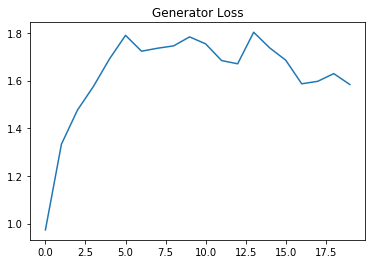

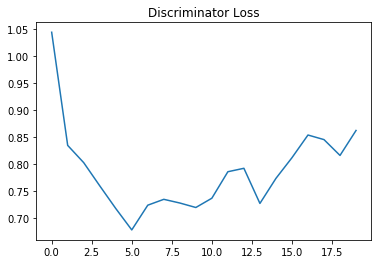

In [235]:
import matplotlib.pyplot as plt
generator_losses = np.load('./cGAN/generator_losses.npy')
plt.plot(list(range(0,generator_losses.shape[0])), generator_losses)
plt.title('Generator Loss')
plt.show()

import matplotlib.pyplot as plt
discriminator_losses = np.load('./cGAN/discriminator_losses.npy')
plt.plot(list(range(0,discriminator_losses.shape[0])), discriminator_losses)
plt.title('Discriminator Loss')
plt.show()

### Sampling

In [236]:
generator.load_state_dict(torch.load("./cGAN/generator.pth"))

"""
TODO: Sample from the noise distribution
"""
generator.eval()
n_samples = 32
with torch.no_grad():
    z = generate_noise(n_samples*n_samples, noise_dim).to(device)
    samples = generator(z)
    save_image(denorm(samples).type(torch.FloatTensor).cpu(), './cGan/samples' + '.png', nrow = n_samples)

TypeError: forward() missing 1 required positional argument: 'labels'